## Assignment by: 

- Filippo Teodoro: b00772555@essec.edu
- Piero Ronchetti: b00782314@essec.edu
- Lorenzo Lo Faso: b00784982@essec.edu

**Sources:**

[Markowitz’s Efficient Frontier in Python [Part 1/2]](https://medium.com/python-data/effient-frontier-in-python-34b0c3043314)

[Efficient Frontier & Portfolio Optimization with Python [Part 2/2]](https://medium.com/python-data/efficient-frontier-portfolio-optimization-with-python-part-2-2-2fe23413ad94)

[Investment Portfolio Optimization - Bradford Lynch
](http://www.bradfordlynch.com/blog/2015/12/04/InvestmentPortfolioOptimization.html)

## Installing Packages

In [ ]:
!pip install rpy2
!pip install quandl
!pip install yfinance

In [ ]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
import yfinance as yf
plt.style.use('fivethirtyeight')
np.random.seed(15)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
'''
The initial set of suggested ETFs is:
______________________________
BIV - US INTERMEDIATE BOND
VCSH - US INVESTMENT GRADE BOND
BNDX - GLOBAL BOND ETF
VNQ - US REIT
JP 1343 - JREIT*
JP 1555 - AU REIT*
SPDR - US STOCK                   #VTI (all US stocks)
VT - GLOBAL STOCK                   #ACWX (world index ex US)
HVST AU - EQUITY DIVIDEND ETF AU*     #Vanguard High Dividend Yield (VYM)/ iShares S&P/ASX High Dividend Yield ETF (IHD) (AU)
______________________________
'''

# data = yf.Tickers("BIV VCSH BNDX VNQ O2FF SPY VT HVSTAX") # returns empty columns
#data = yf.Tickers("BIV VCSH BNDX VNQ VOO VT") 
#data = yf.Tickers("BIV VCSH BNDX VNQ VOO VT AGG VGK VWO VSS")
#data = yf.Tickers("AGG VGK VWO VSS BIV VOO VT VCHS BNDX VNQ IAU BCI")
data = yf.Tickers("AGG VGK VWO VSS BIV VOO VT BNDX VNQ IAU")
# data = yf.Tickers("VNQ SPY VT") #indexes
# data = yf.Tickers("BIV VCSH BNDX") # bonds
# data = yf.Tickers("ICLN QQQ VOO PEJ VB") # VIXY, BNDX, XVV, GDX, VCSH
# data = yf.Tickers("AAPL MSFT VCSH")
# data.info
hist = data.history(start="2014-1-1") # end="2020-12-31")    
hist = hist['Close']
hist.shape
# hist = hist.replace(np.nan, 0) 
hist = hist.rename_axis('date')
hist.head()

[*********************100%***********************]  10 of 10 completed


,AGG,BIV,BNDX,IAU,VGK,VNQ,VOO,VSS,VT,VWO
date,,,,,,,,,,
2014-01-02,89.373848,66.915970,42.784927,11.88,45.389969,48.320042,146.810410,83.881332,49.741524,32.867905
2014-01-03,89.407379,66.981369,42.750481,12.01,45.397850,48.589455,146.679047,84.560074,49.792530,32.826504
2014-01-06,89.524879,67.120255,42.853901,12.01,45.437290,48.836407,146.311234,84.733894,49.656528,32.511898
2014-01-07,89.566879,67.177483,42.957348,11.95,45.744877,49.053429,147.222061,84.973915,49.886024,32.644356
2014-01-08,89.298378,66.866951,42.853901,11.89,45.721222,48.813957,147.283340,84.957397,49.894539,32.586414


In [ ]:
table = hist
#biv = yf.Ticker("BIV")
#biv.info

## Importing Data

In [ ]:
'''
quandl.ApiConfig.api_key = 'ymzfcPHGK5mwh7Px9Abv'
stocks = ['AAPL','AMZN','GOOGL','FB']
# stocks = ['BIV','VCSH','BNDX','VNQ']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2018-1-1', 'lte': '2019-12-31' }, paginate=True)
data.head()

data.info()

df = data.set_index('date')
table = df.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()
'''

"\nquandl.ApiConfig.api_key = 'ymzfcPHGK5mwh7Px9Abv'\nstocks = ['AAPL','AMZN','GOOGL','FB']\n# stocks = ['BIV','VCSH','BNDX','VNQ']\ndata = quandl.get_table('WIKI/PRICES', ticker = stocks,\n                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },\n                        date = { 'gte': '2018-1-1', 'lte': '2019-12-31' }, paginate=True)\ndata.head()\n\ndata.info()\n\ndf = data.set_index('date')\ntable = df.pivot(columns='ticker')\n# By specifying col[1] in below list comprehension\n# You can select the stock names under multi-level column\ntable.columns = [col[1] for col in table.columns]\ntable.head()\n"

Text(0, 0.5, 'price in $')

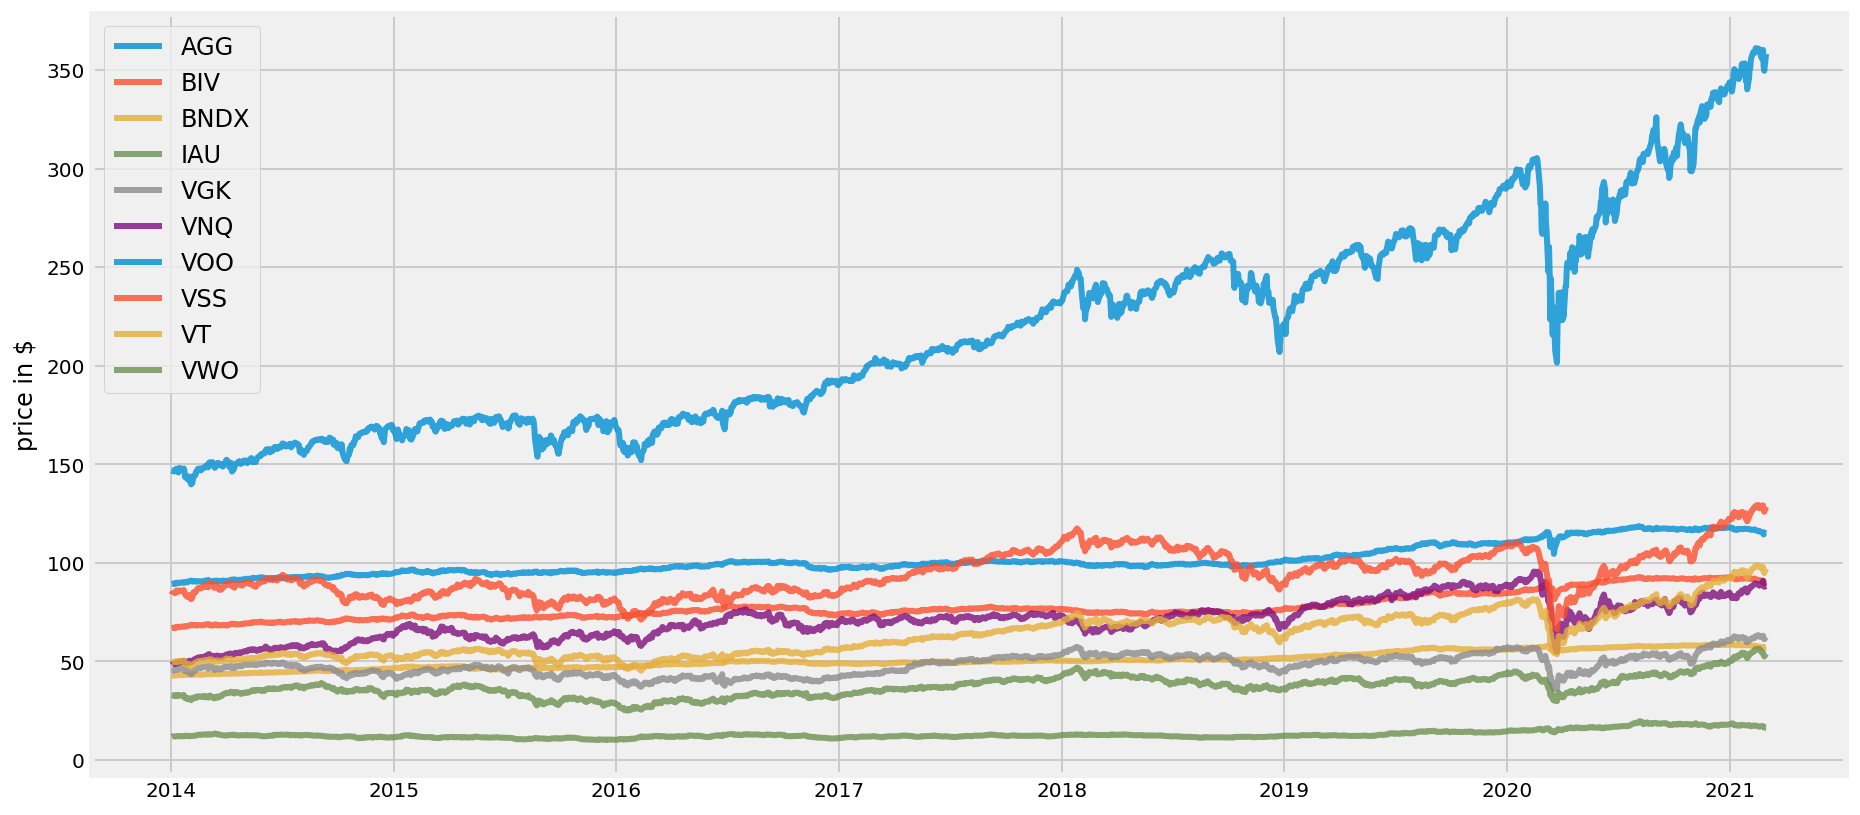

In [ ]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

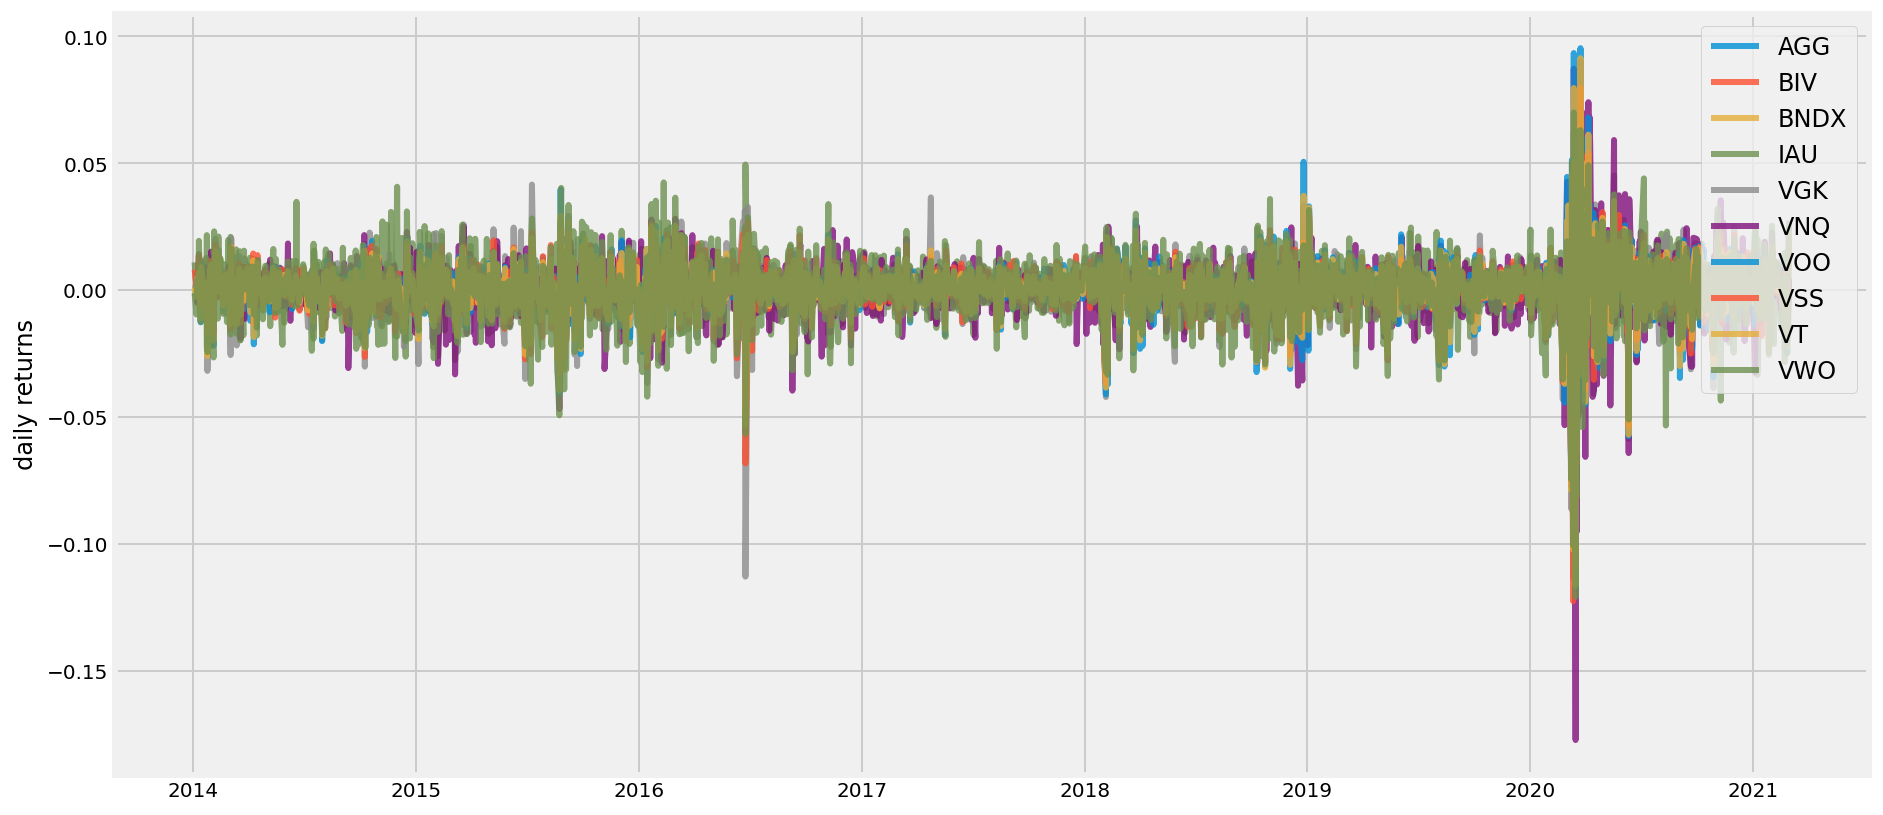

In [ ]:
returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

## Random Portfolios Generation

"portfolio_annual_performance" function will calculate the returns and volatility, and to make it as an annualised calculation I take into account 252 as the number of trading days in one year. "random_portfolios" function will generate portfolios with random weights assigned to each stock, and by passing num_portfolios argument, you can decide how many random portfolios you want to generate.

In [ ]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(table.shape[1])
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [ ]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 10000
risk_free_rate = 0.0110    # https://www.gurufocus.com/economic_indicators/37/10year-treasury-constant-maturity-rate

display_simulated_ef_with_random First generates random portfolio and gets the results (portfolio returns, portfolio volatility, portfolio Sharpe ratio) and weights for the corresponding result. Then by locating the one with the highest Sharpe ratio portfolio, it displays maximum Sharpe ratio portfolio as red star sign. And does similar steps for minimum volatility portfolio, and displays it as the green star on the plot. All the randomly generated portfolios will be also plotted with colour map applied to them based on the Sharpe ratio. The bluer, the higher Sharpe ratio.
And for these two optimal portfolios, it will also show how it allocates the budget within the portfolio.

In [ ]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=table.columns, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx], index=table.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*9*table.shape[1])
    print("Maximum Sharpe Ratio Portfolio Allocation", "\n")
    print("Annualised Return:", round(rp*100,2))
    print("Annualised Volatility:", round(sdp*100,2), "\n")
    print(max_sharpe_allocation)
    print("-"*9*table.shape[1])
    print("Minimum Volatility Portfolio Allocation", "\n")
    print("Annualised Return:", round(rp_min*100,2))
    print("Annualised Volatility:", round(sdp_min*100,2), "\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

------------------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation 

Annualised Return: 5.73
Annualised Volatility: 4.95 

              AGG    BIV   BNDX    IAU   VGK   VNQ  VOO  VSS    VT   VWO
allocation  22.98  24.13  20.29  10.99  2.86  3.19  9.8  3.0  2.35  0.41
------------------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation 

Annualised Return: 4.74
Annualised Volatility: 4.01 

             AGG    BIV  BNDX   IAU   VGK   VNQ   VOO   VSS    VT   VWO
allocation  25.1  39.72  17.6  6.44  2.28  1.89  2.21  3.47  0.82  0.48


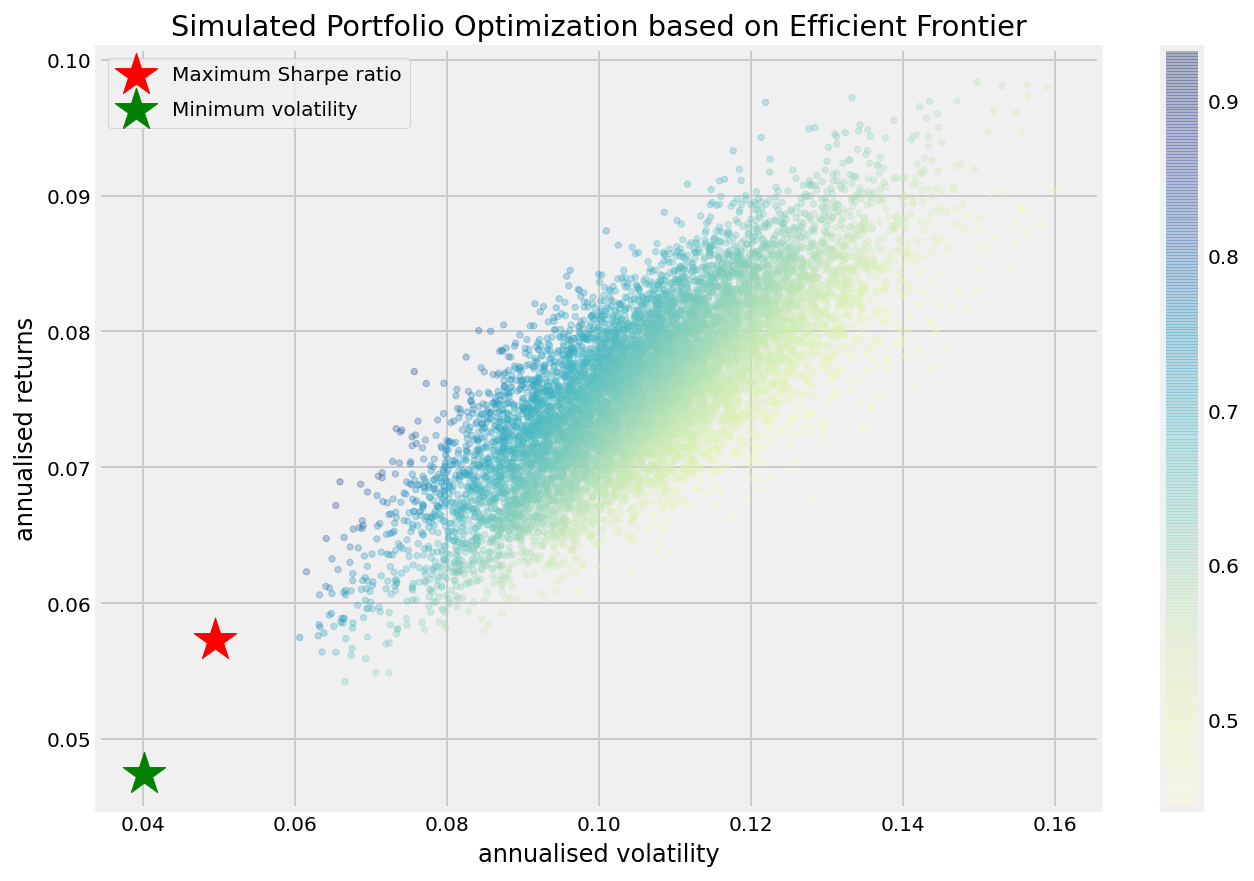

In [ ]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

## With SCO Minimize

Scipy's optimize function works like Excel's Solver, but there's no 'maximize', so as an objective function you need to pass something that should be minimized. That is why the first "neg_sharpe_ratio" is computing the negative Sharpe ratio.

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

The above constraint is saying that sum of x should be equal to 1. You can think of the 'fun' part construction as '1' on the right side of equal sign has been moved to the left side of the equal sign.

'np.sum(x) == 1' has become 'np.sum(x)-1'

"bounds" is giving another limit to assign random weights, by saying any weight should be inclusively between 0 and 1. You cannot give minus budget allocation to a stock or more than 100% allocation to a stock.

In [ ]:
# scipy optimize can only minimize, not maximize so we use the negative sharpe ration

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


We can also define the optimizing function for calculating minimum volatility portfolio.

In [ ]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

The first function "efficient_return" is calculating the most efficient portfolio for a given target return, and the second function "efficient_frontier" will take a range of target returns and compute efficient portfolio for each return level.

In [ ]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints) # Sequential Least Squares Programming 
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients


Let's try to plot the portfolio choice with maximum Sharpe ratio and minimum volatility also with all the randomly generated portfolios. But this time we are not picking the optimal ones from the randomly generated portfolios, but we are actually calculating by using Scipy's 'minimize' function. And the below function will also plot the efficient frontier line.

In [ ]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x, index=table.columns, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x, index=table.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100, 2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*9*table.shape[1])
    print("Maximum Sharpe Ratio Portfolio Allocation", "\n")
    print("Annualised Return:", round(rp*100, 2))
    print("Annualised Volatility:", round(sdp*100, 2), "\n")
    print(max_sharpe_allocation)
    print("-"*9*table.shape[1])
    print("Minimum Volatility Portfolio Allocation", "\n")
    print("Annualised Return:", round(rp_min*100, 2))
    print("Annualised Volatility:", round(sdp_min*100, 2, ), "\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.12, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

------------------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation 

Annualised Return: 5.36
Annualised Volatility: 3.4 

            AGG    BIV   BNDX  IAU  VGK  VNQ    VOO  VSS   VT  VWO
allocation  0.0  25.99  62.22  0.0  0.0  0.0  11.79  0.0  0.0  0.0
------------------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation 

Annualised Return: 4.34
Annualised Volatility: 3.01 

             AGG  BIV   BNDX  IAU   VGK  VNQ   VOO  VSS   VT  VWO
allocation  5.48  8.7  82.99  0.0  1.02  0.0  1.82  0.0  0.0  0.0


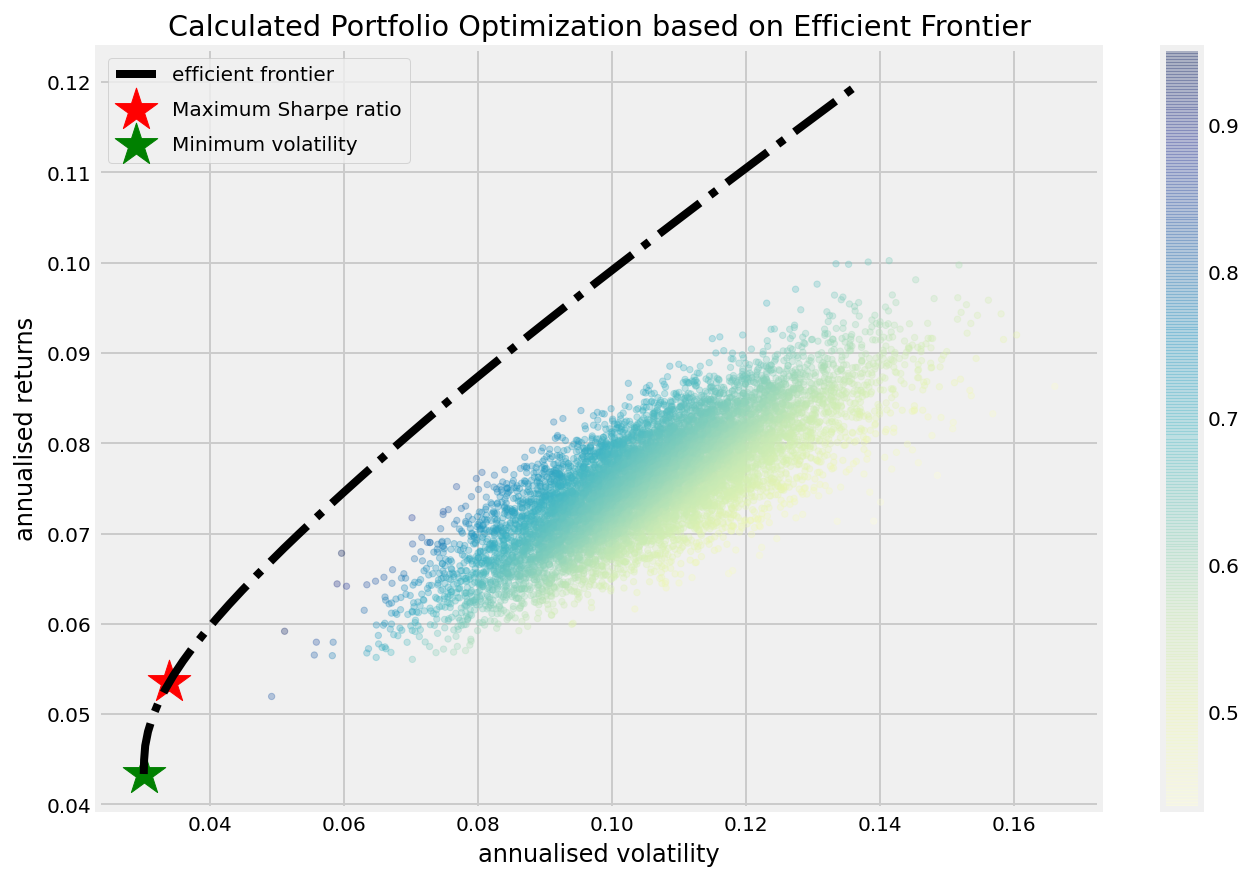

In [ ]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)


Instead of plotting every randomly generated portfolio, we can plot each individual stocks on the plot with the corresponding values of each stock's annual return and annual risk. This way we can see and compare how diversification is lowering the risk by optimising the allocation.

In [ ]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    # print(max_sharpe, '\n')
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    # print(sdp, rp, '\n')
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x, index=table.columns, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    # print(max_sharpe_allocation, '\n')

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x, index=table.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print("-"*9*table.shape[1])
    print("Maximum Sharpe Ratio Portfolio Allocation", "\n")
    print("Annualised Return:", round(rp*100,2))
    print("Annualised Volatility:", round(sdp*100,2), "\n")
    print(max_sharpe_allocation)
    print("-"*9*table.shape[1])
    print("Minimum Volatility Portfolio Allocation", "\n")
    print("Annualised Return:", round(rp_min*100,2))
    print("Annualised Volatility:", round(sdp_min*100,2), "\n")
    print(min_vol_allocation)
    print("-"*9*table.shape[1])
    print("Individual Stock Returns and Volatility", "\n")
    for i, txt in enumerate(table.columns):
        print(txt,":","annuaised return",round(an_rt[i]*100,2),", annualised volatility:",round(an_vol[i]*100,2))
    print("-"*9*table.shape[1])
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.12, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    #print(efficient_portfolios)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

------------------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation 

Annualised Return: 5.36
Annualised Volatility: 3.4 

            AGG    BIV   BNDX  IAU  VGK  VNQ    VOO  VSS   VT  VWO
allocation  0.0  25.99  62.22  0.0  0.0  0.0  11.79  0.0  0.0  0.0
------------------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation 

Annualised Return: 4.34
Annualised Volatility: 3.01 

             AGG  BIV   BNDX  IAU   VGK  VNQ   VOO  VSS   VT  VWO
allocation  5.48  8.7  82.99  0.0  1.02  0.0  1.82  0.0  0.0  0.0
------------------------------------------------------------------------------------------
Individual Stock Returns and Volatility 

AGG : annuaised return 3.63 , annualised volatility: 4.25
BIV : annuaised return 4.29 , annualised volatility: 4.35
BNDX : annuaised return 4.15 , annualised volatility: 3.08
IAU : annuaised return 5.54 , annualised volatility

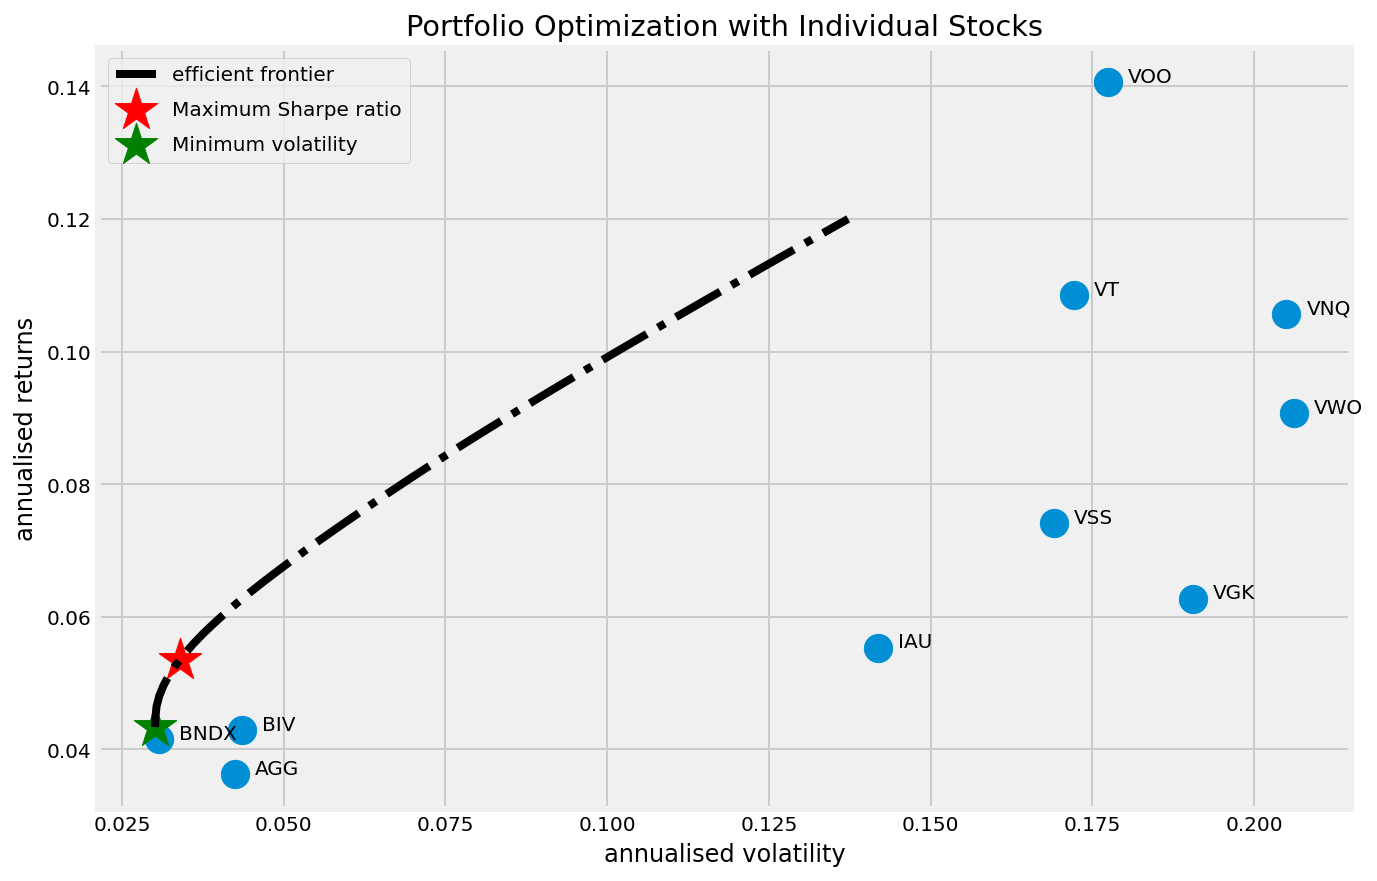

In [ ]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

Package

https://pypi.org/project/pyportfolioopt/

In [ ]:
!pip install PyPortfolioOpt
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [ ]:
# Read in price data
df = hist

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
# ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights, '\n')
ef.portfolio_performance(verbose=True)

OrderedDict([('AGG', 0.0), ('BIV', 0.28123), ('BNDX', 0.57898), ('IAU', 0.0), ('VGK', 0.0), ('VNQ', 0.0), ('VOO', 0.13978), ('VSS', 0.0), ('VT', 0.0), ('VWO', 0.0)]) 

Expected annual return: 5.5%
Annual volatility: 3.6%
Sharpe Ratio: 0.97


(0.05487375087618197, 0.03587801358295532, 0.9720089657569434)

In [ ]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)

da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'BIV': 31, 'BNDX': 100, 'VOO': 4}
Funds remaining: $31.53


In [ ]:
def polynomial_regression_model(degree):
    "Creates a polynomial regression model for the given degree"
    
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(x.reshape(-1, 1))
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state = 0)
    
    reg = LinearRegression().fit(X_train, y_train)
    
    # predicting on training data-set
    y_train_predicted = reg.predict(X_poly)

    # predicting on test data-set
    y_test_predict = reg.predict(poly.fit_transform(X_test.reshape(-1, 1))) 
    
    '''
    print('Coefficents: \n', reg.coef_, '\n')
    print('Intercept: \n', reg.intercept_, '\n')
    r2 = reg.score(X_test, y_test)
    print('r2: \n', r2)
    '''
    
    #return np.concatenate([y_train_predicted,y_test_predict])
    return y_train_predicted # this then feeds the Output array
    
# polynomial_regression_model(1)

# Output = np.array([polynomial_regression_model(1),
#        polynomial_regression_model(3),
#        polynomial_regression_model(6),
#        polynomial_regression_model(9)])